In [1]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import control
import control.matlab
%matplotlib inline 

Здесь мы импортировали 

kplace: [[-558.57267514  384.19186063  877.0750133 ]]
place eig: [-1. -2. -3.]
klqr: [[ -0.33389698 164.67361867 316.22776602]]
lqr eig: [-0.31511936+0.j         -1.85626434+1.84912546j -1.85626434-1.84912546j]
M0: [[-0.0006    ]
 [-0.0022    ]
 [-0.0001    ]
 [-0.00076448]
 [-0.00216904]
 [-0.0003184 ]
 [-0.00092123]
 [-0.00213834]
 [-0.00053371]
 [-0.00107052]
 [-0.00210791]
 [-0.00074595]
 [-0.0012126 ]
 [-0.00207775]
 [-0.00095516]
 [-0.00134773]
 [-0.00204787]
 [-0.00116136]
 [-0.00147613]
 [-0.00201826]
 [-0.00136458]
 [-0.00159805]
 [-0.00198893]
 [-0.00156485]
 [-0.00171371]
 [-0.00195989]
 [-0.00176219]
 [-0.00182333]
 [-0.00193113]
 [-0.00195663]]


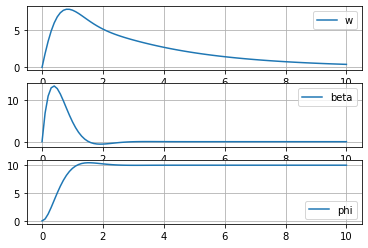

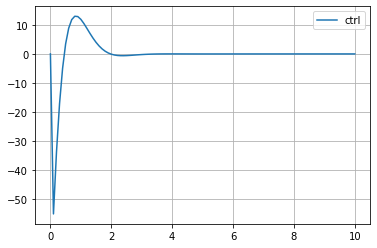

In [40]:
class Model:

    kp = -np.array([1, 1, 1])
    ki = np.array([0,0,0])
    x0 = np.array([0,0,0])
    xd = np.array([0,0,10*math.pi/180])
    dt = 0.1
    tt = np.array([0, dt])
    T = 10
    TT = np.arange(0,T+dt,dt)
    u0 = 0
    xx = np.array(x0)
    uu = np.array([0])
    ei = np.array([0,0,0])
    kplace = []
    klqr = []
    kdlqr = np.array([-0.3510, 150.5355, 264.5792])
    Kmpc = []
    A = np.array([[-0.3176, 0.852, 0],
                 [-0.0102, -0.1383, 0],
                 [0, 1, 0]])
    B = np.vstack((-0.005,
                 -0.0217,
                 0))
    C = np.diag([1,1,1])
    P = 10
    Ad = np.array([[0.9687, 0.0833, 0],
                   [-0.0010, 0.9862, 0],
                   [-0.0001, 0.0993, 1.0000]])
    Bd = np.vstack((-0.0006,
                   -0.0022,
                   -0.0001))
    
    def mpc_lin(R0,Q0):
        P = Model.P
        C = Model.C
        A = Model.Ad
        B = Model.Bd
        R = np.kron(np.eye(P),R0)
        Q = np.kron(np.eye(P),Q0)
        L = np.array([])
        M0 = []
        
        for i in range(1, P+1):
            if (L.shape == (0,)):
                L = C @ A
                M0 = C @ B
               # print(f'M0: {M0.shape}')
            else:
                L = np.vstack((L, C @ np.linalg.matrix_power(A,i)))
                #print(f'M0: {C @ np.linalg.matrix_power(A,i-1) @ B}')
                M0 = np.vstack((M0, C @ np.linalg.matrix_power(A,i-1) @ B))
        
        print(f'M0: {M0}')
        
        return 0

    def du(in_,t,ep):
        return ep
    
    def place(self, x):
        ep = x-self.xd
        u = self.kplace @ ep
        return u
    
    def lqr(self, x):
        ep = x-self.xd
        u = self.klqr @ ep
        return u
    
    def dlqr(self, x):
        ep = x-self.xd
        u = self.kdlqr @ ep
        return u
    
    def pid(self, x):
        ep = x-self.xd
        self.ei = odeint(Model.du,self.ei,self.tt,args=(ep,))[-1]
        u = self.kp @ ep + self.ki @ self.ei
        return u

    def ctrl(self,x):
        return self.lqr(x)

    def rp(in_,t,u):
        x = in_.reshape((3,1))
        
        if (u.shape == (1,)):
            u = u[0]
        if (u.shape == (1,1)):
            u = u[0,0]

        aa = Model.A @ x
        bb = Model.B * u
        dx = aa + bb
        #print(f'DX:{dx[:,0]}')
        
        return dx[:,0]

    def state(self,u,x0):
        x = odeint(Model.rp,x0,self.tt,args=(u,))[-1,:]
        return x
    
    def step(self,x0,u0):
        u = self.ctrl(x0)
        x = self.state(u,x0)
        return (x,u)

    def main_cycle(self):
        x = self.x0
        u = self.u0
        for t in self.TT[1:]:
            (x,u) = self.step(x,u)
            self.xx = np.vstack((self.xx,x))
            self.uu = np.vstack((self.uu,u))
            
    def linearize(self):
        p = 1*np.array([-1,-2,-3])
        self.kplace = -control.matlab.place(Model.A,Model.B,p)
        print(f"kplace: {self.kplace}")
        w,v = np.linalg.eig(Model.A + Model.B @ self.kplace)
        print(f"place eig: {w}")
        
        Q = np.diag(np.array([1, 1, 1e3]))
        R = 1e-2
        self.klqr,S,E = control.lqr(Model.A,Model.B,Q,R)
        self.klqr = -self.klqr
        print(f"klqr: {self.klqr}")
        w,v = np.linalg.eig(Model.A + Model.B @ self.klqr)
        print(f"lqr eig: {w}")   
        
        Model.mpc_lin(Q,R)
        
    def __init__(self):
        self.linearize()
        pass

m = Model()
m.main_cycle()
m.xx *= 180/math.pi

plt.figure(1)
plt.subplot(3,1,1)
plt.plot(m.TT,m.xx[:,0],label='w')
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(m.TT,m.xx[:,1],label='beta')
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(m.TT,m.xx[:,2],label='phi')
plt.legend()
plt.grid()

plt.figure(2)
plt.plot(m.TT,m.uu,label='ctrl')
plt.legend()
plt.grid()

